## run notebooks

In [68]:
%run "../Notebooks/initialization.ipynb"
%run "../Notebooks/Input_selection_functions.ipynb"
%run "../Notebooks/Stitching_functions.ipynb"
%run "../Notebooks/Visualization_functions.ipynb"
%run "../Notebooks/Downsampling_and_outliers_functions.ipynb"
%load_ext autoreload

loading directory file
----------------------------------------
loaded variables from initialization file: 
> myparams, myconfiguration_file
> list_picked_id_source, list_picked_id_target
> data_folder
----------------------------------------
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the pointclouds

In [18]:
# default
all_paths_images,all_paths_ply, num_images,labels = load_input(data_folder)

default set:
-imgfolder, contains 30 images 
-plyfolder, contains 30 ply  
found labels file: 
['External', 'Internal', 'Upper']


In [22]:
all_seq_pcd = all_files_containing("stitched_seq", extension = ".pcd")
all_seq_pcd = sorted([seq[2:]for seq in all_seq_pcd])

['stitched_seq_0.pcd', 'stitched_seq_1.pcd', 'stitched_seq_2.pcd']

In [23]:
list_stitches = [o3d.io.read_point_cloud(this_seq) for this_seq in all_seq_pcd]
labels_stitches = ["stitched_%s"%thislab for thislab in labels]
color_stitches = [[1, 0.706, 0],[0, 0.651, 0.929],[0,0.7,0.3]]

## Many plots

In [27]:
# plot a list of geometries
custom_draw_geometry([list_stitches[:]],
                     mytitle = [labels_stitches[:]],
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = False,
                     rotate = True)

[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### downsampling

In [75]:
downsampled_stitches = downsample_list_stitches(list_stitches,
                                                #labels_stitches,color_stitches , 
                                                voxel_size = 0.3,
                                                visualization_on = True,
                                                print_statements = True)

Downsampled_pcl_1
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
Downsampled_pcl_1
number of points original :  230502
number of points with voxel down sample : 16013

Downsampled_pcl_2
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
Downsampled_pcl_2
number of points original :  227230
number of points with voxel down sample : 11904

Downsampled_pcl_3
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
Downsampled_pcl_3
number of points original :  219648
number of points with voxel down sample : 13335



## Merge the external, upper, internal together

The process is in one step, if only with two sequences, and two steps if with three. 

Again here the process is fully spelled out.
The downsampling process is very important in between, since the number of pointcloud is now quite high.

In [44]:
downsampled_stitches[1]

PointCloud with 82782 points.

In [45]:
downsampled_stitches[2]

PointCloud with 80867 points.

### Step 1- 

In [34]:
# timestamp
dt_string = mytimestamp()
print(dt_string)

# initialize 
voxel_size  =0.2 # with 0.1 doesnt work!
i = 1
j = 2
source_label = labels_stitches[i][9:-3] # just labels parsing
target_label =labels_stitches[j][9:-3]

source = list_stitches[i]
target = list_stitches[j]

processed_source = downsampled_stitches[i]
processed_target = downsampled_stitches[j]

mytitle= dt_string+"-%s_%s"%(source_label,target_label)
start = timer()

#MAIN
source_output, target_output, transformation_1 = stitch_sequences(processed_source,processed_target,
                                                  source_label,target_label,
                                                  mmax_iteration = 10**7, # lower than this doesnt work
                                                  mmax_validation = 0.999,
                                                  print_statements = True, 
                                                  visualization_on = False  
                                                 )

end = timer()
print (f"duration: {end-start}")
draw_registration_result(source_output, target_output, transformation_1, title = dt_string+"Downsampled Registration results")


## apply transformation on original 
draw_registration_result(source, target, transformation_1, title = dt_string+"Full Registration results")

17012021-00h25m36s-
allpc_downsampled_Inter_Up
removing outliers

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
Transformation is:
[[  0.98776226  -0.04342407   0.1498001   -8.90944975]
 [ -0.0459809    0.83669621   0.54573364 -27.09216096]
 [ -0.14903515  -0.54594304   0.82446026  12.03786595]
 [  0.           0.           0.           1.        ]]
overlapping points :  115
RegistrationResult with fitness=8.005012e-03, inlier_rmse=9.902971e-02, and correspondence_set size of 115
Access transformation to get result.

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.200.
Transformation is:
[[  0.98776504  -0.04429409   0.14952681  -8.88833858]
 [ -0.04679505   0.83044787   0.55512752 -27.52566747]
 [ -0.14876309  -0.55533267   0.81821462  12.39631735]
 [  0.           0.           0.           1.        ]]
overlapping points :  59126
RegistrationResult with fitness=7.142374e-01, inlier_rmse=7.177783e-02, and correspondence_set siz

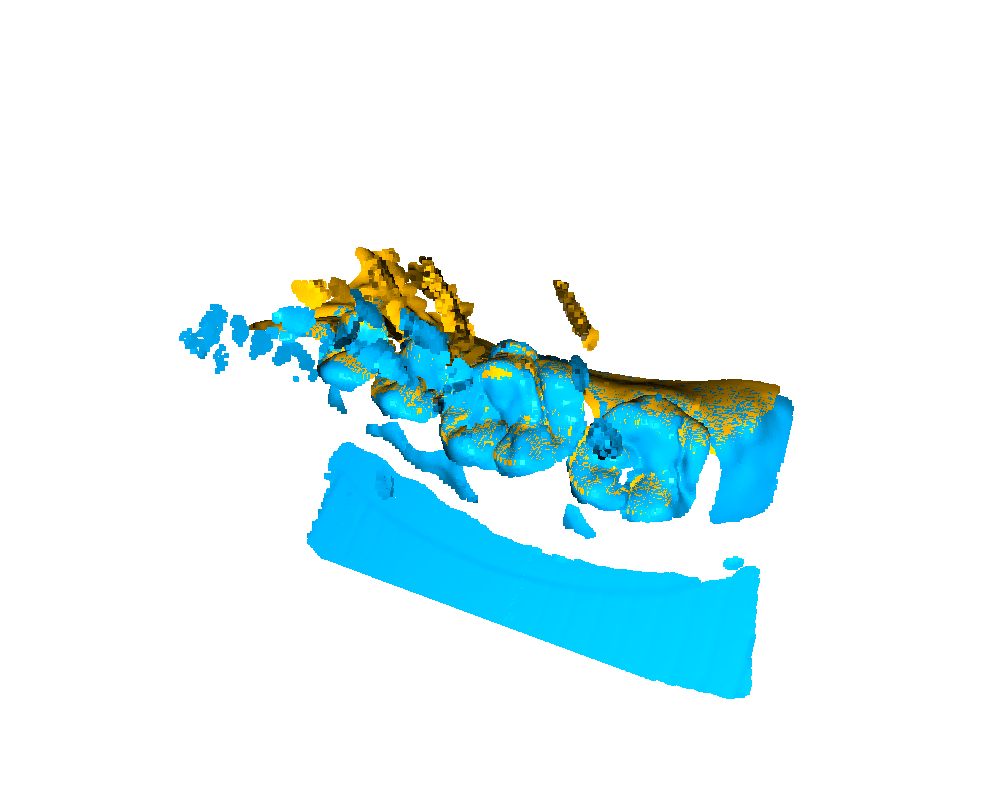

In [35]:
# after manual changing in visualization mode
newest = last_file_containing("stitch_seq_1_2", extension = '.png')
Im(filename=newest,width = 800)

In [36]:
stitch_seq_1_2 = save_registration_result(source, target, transformation_1, 
                                        title= "seq_1_2", 
                                        save_result = True,
                                        visualize_result = False)

## downsample new one for next step

In [41]:
downsampled_seq_1_2 = downsample_list_stitches([stitch_seq_1_2],
                                               ["seq_1_2"],color_stitches= None , 
                                                voxel_size = 0.3,
                                                visualization_on = True,
                                                print_statements = False)

Downsampled_seq_1_2
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


## Step 2-

In [57]:
# timestamp
dt_string = mytimestamp()
print(dt_string)

# initialize 
voxel_size  =0.2 # with 0.1 doesnt work!
i = 0
j = 2
source_label = labels_stitches[i][9:-3] # just labels parsing
target_label =labels_stitches[j][9:-3]

source = list_stitches[i]
target = list_stitches[j]

processed_source = downsampled_stitches[i]
processed_target = downsampled_stitches[j]

mytitle= dt_string+"-%s_%s"%(source_label,target_label)
start = timer()

#MAIN
source_output, target_output, newpointcloud ,all_results = stitch_sequences(processed_source,processed_target,
                                                                              source_label,target_label,
                                                                              mmax_iteration = 10**7, # lower than this doesnt work
                                                                              mmax_validation = 0.999,
                                                                              print_statements = True, 
                                                                              visualization_on = False,
                                                                              myoverlapping_factor = 0.25,
                                                                              maxnumattempts = 10
                                                                             )

end = timer()

17012021-01h15m54s-
allpc_downsampled_Exter_Up
removing outliers
number of points in clouds
(0, 92364)
(1, 80867)
valuetoreach:  20216.75
ATTEMPT 0

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
Transformation is:
[[ 0.56962867 -0.81614292 -0.09712835  5.8949593 ]
 [ 0.8211908   0.57006327  0.02595249  4.11955852]
 [ 0.03418837 -0.09454419  0.99493344  0.7442669 ]
 [ 0.          0.          0.          1.        ]]
overlapping points :  9
RegistrationResult with fitness=5.086470e-04, inlier_rmse=9.358953e-02, and correspondence_set size of 9
Access transformation to get result.

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.200.
Transformation is:
[[ 7.03944952e-01 -7.10249330e-01  2.71923076e-03  3.46235859e+00]
 [ 7.10138123e-01  7.03893730e-01  1.54098284e-02  5.05186523e+00]
 [-1.28588698e-02 -8.91664146e-03  9.99877564e-01 -3.38357016e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
overlapping poi

Transformation is:
[[ 0.98778158 -0.04942231 -0.14780051  7.01439866]
 [-0.04133557  0.83133062 -0.55423892 31.4419625 ]
 [ 0.15026286  0.55357641  0.81913017  9.15008052]
 [ 0.          0.          0.          1.        ]]
overlapping points :  19606
RegistrationResult with fitness=2.122688e-01, inlier_rmse=7.748965e-02, and correspondence_set size of 19606
Access transformation to get result.
ATTEMPT 9

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
Transformation is:
[[ 0.98893356  0.05734451 -0.13682846  7.0997257 ]
 [-0.12730546  0.80159243 -0.58415999 33.07844822]
 [ 0.07618229  0.59511443  0.80002192 10.66560963]
 [ 0.          0.          0.          1.        ]]
overlapping points :  8
RegistrationResult with fitness=4.521307e-04, inlier_rmse=1.248159e-01, and correspondence_set size of 8
Access transformation to get result.

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.200.
Transformation is:
[[ 0.98778141 -0.0494212

In [70]:
newpointcloud = save_registration_result(source, target, transformation_2,
                             
                             #visualization parameters
                             title = "stitch_seq_0_2", mytuples = None, 
                             params = None, #camera parameters,json file (P)
                             fov_step  = None, 
                             configuration_file = None, #object properties ,json file (O)
                             rotate = False,
                             
                             save_result = True,
                             visualize_result = True)

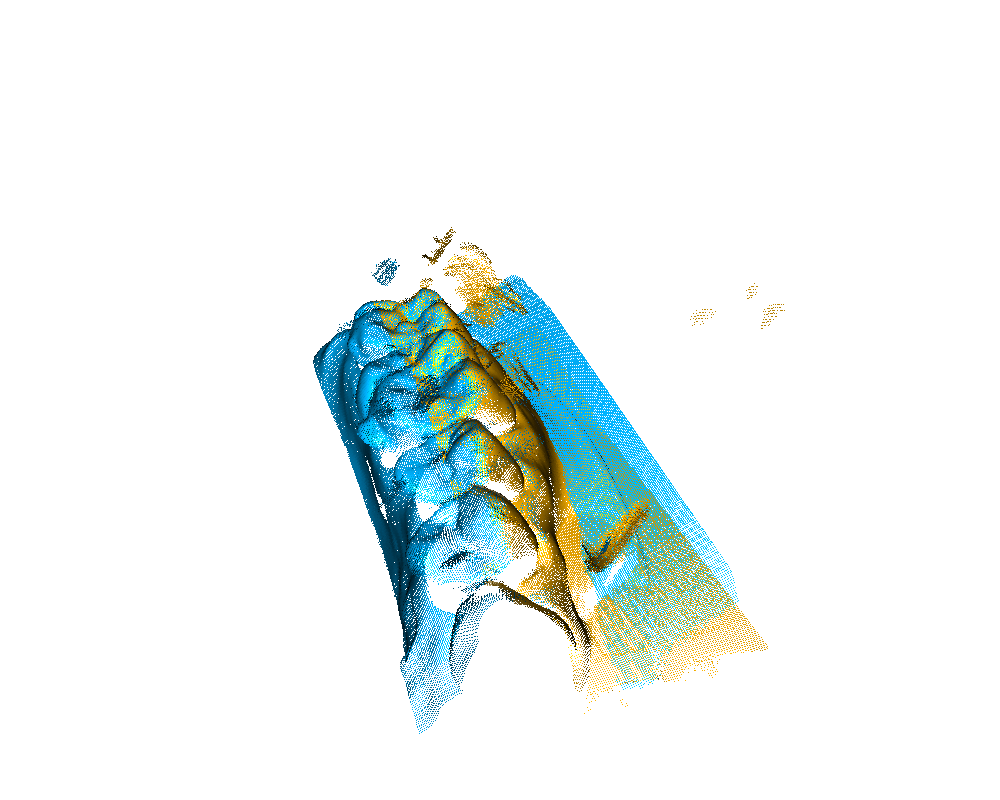

In [71]:
#o3d.visualization.draw_geometries([list_new_pointclouds[-1]])
stitched_seq_0_2 = newpointcloud


custom_draw_geometry(stitched_seq_0_2,
                     mytitle = str(mytimestamp())+ "stitch_seq_0_2",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)
# after manual changing in visualization mode
newest = last_file_containing("stitch_seq_0_2", extension = '.png')
Im(filename=newest,width = 800)

In [59]:
print (f"duration: {end-start}")

## apply transformation on original 
draw_registration_result(source, target, transformation_2, title = dt_string+"Full Registration results")

duration: 557.3401757850079


In [ ]:
# after manual changing in visualization mode
newest = last_file_containing("stitch_seq_0_2", extension = '.png')
Im(filename=newest,width = 800)

In [43]:
downsampled_stitches[0]

PointCloud with 92364 points.

In [54]:
# input 
voxel_size  =0.2
j = 0
source_label = "seq_1_2"
target_label =labels_stitches[j][9:-3]

processed_source = downsampled_seq_1_2[0]
processed_target = downsampled_stitches[j] 

mytitle= dt_string+"-%s_%s"%(source_label,target_label)


start = timer()

source_output, target_output,transformation_2 = tqdm(stitch_sequences(processed_source,processed_target,
                                                                  source_label,target_label,
                                                                  mmax_iteration = 10**7,
                                                                  mmax_validation = 0.999,
                                                                  print_statements = True,
                                                                  visualization_on = False,
                                                                  myoverlapping_factor = 0.01,
                                                                  maxnumattempts = 10
                                                                 )
                                                )


end = timer()
print (f"duration: {end-start}")
draw_registration_result(source_output, target_output, transformation_2, title = "Downsampled Registration results")

source = stitch_seq_1_2
target = list_stitches[j]
draw_registration_result(source, target, transformation_2, title = "Registration results")

allpc_downsampled_seq_1_2_Exter
removing outliers
number of points in clouds
(0, 18936)
(1, 92364)
valuetoreach:  923.64

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
Transformation is:
[[-7.31071461e-01 -6.21291053e-01 -2.82014090e-01  2.05063809e+01]
 [-4.10201928e-02  4.52602558e-01 -8.90768358e-01  4.36223682e+01]
 [ 6.81066710e-01 -6.39647053e-01 -3.56370292e-01  5.08501855e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
overlapping points :  3
RegistrationResult with fitness=4.545455e-03, inlier_rmse=1.912270e-02, and correspondence_set size of 3
Access transformation to get result.

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.200.
Transformation is:
[[-7.37883045e-01 -6.09002683e-01 -2.90937010e-01  2.11383851e+01]
 [-4.26110616e-02  4.72238671e-01 -8.80440194e-01  4.32905732e+01]
 [ 6.73582147e-01 -6.37264757e-01 -3.74407160e-01  5.18532484e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e

  0%|          | 0/3 [00:00<?, ?it/s]

duration: 266.8321533779963


In [57]:
mytitle

'12012021-13h51m53s-upper_external_internal'

In [59]:
#save it
complete = save_registration_result(source, target, transformation_2, 
                                        title= mytitle, 
                                        save_result = False,
                                        visualize_result = False)

custom_draw_geometry(complete,
                     mytitle = "complete stitch",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = False,
                     rotate = True)

loading parameters: 
  ./ScreenCamera_2021-01-12-10-28-18.json
loading configuration file: 
  RenderOption_2021-01-12-10-24-27.json
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [60]:
get_num_points([complete])

[677380]

In [61]:
o3d.io.write_point_cloud("complete.pcd", complete)
o3d.io.write_point_cloud(dt_string+"complete.pcd", complete)

True